# Analysis of Ar39 simulations by CJ
In this notebook, we aim to analyse the simulations of 1e6 Ar39 decays.
Since this is a preliminary study, we will structure the analysis as:
- Analysis of energy spectrum, in particular energy deposited in Ar39 and energy detected.
- Analysis of space to see the localization of energy deposition with respect to the original starting point of decay.


In [33]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [34]:
# Load Ar39 data
dir_in = os.path.join("..", "Data", "ar39")
filename = "all_ar39.csv"

df = pd.read_csv(os.path.join(dir_in, filename), index_col=False)
df.time = df.time.astype("float")
df["sec"] = df.time / 1000000000    # add field for time in seconds
df = df.sort_values("time")

**Note**: CJ root files contains `2185641` entries, our csv exportation only `2185013`. The reason is that CJ simulates primaries in ROI but collect all the entries of secondaries in LAr volume. Then, during the preprocessing, we cut off all entries not in ROI, explaining the small data reduction.

## Analsysis of energy
In this section, we compare the spectrum of energy deposition by Ar39's beta decays. However, we note that the tracknumber are somehow *reused* , in the sense that there are electrons with the same tracknumber but with a large difference in time. Maybe, G4 use the tracknumber to identify the particle at runtime but this identifier is not unique in the whole event simulation.

To solve this issue, we know that beta emissions and depositions occurs very fast in time. Then, considering the slow decay rate of Ar39, we can assume that in each event there are no multiple beta decays in the same second.

Then, we group the entry of each decay, simply grouping by `eventnumber` and `sec` (`time` in seconds).

The **simulated energy depositions** are **compared with** the **Ar39's Beta spectrum** (taken from M.Schwarz). 
The result are illustrated in the plot below.

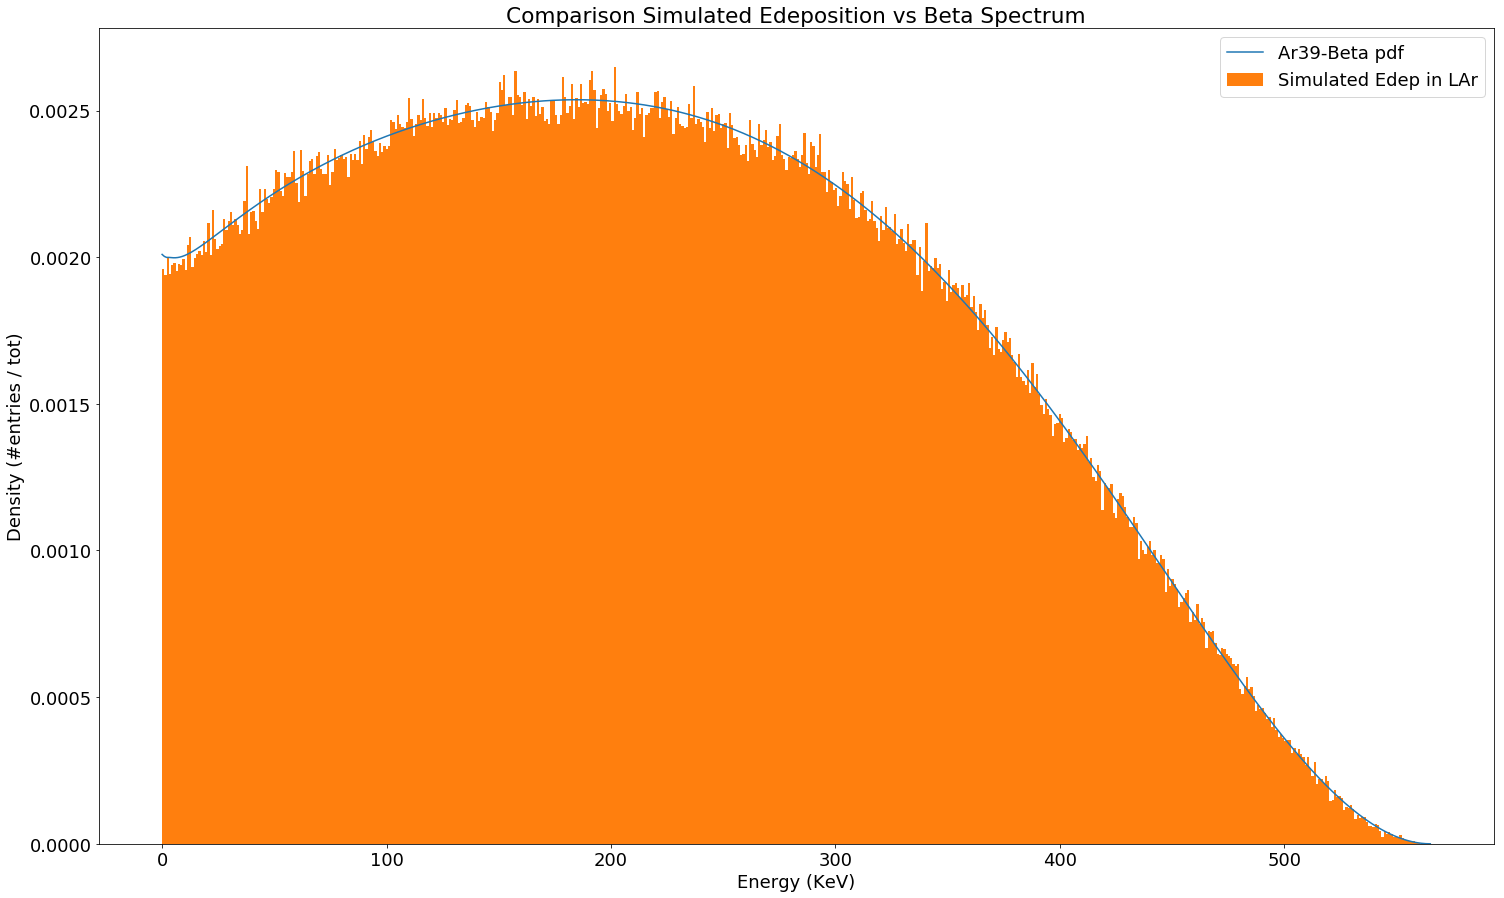

In [35]:
ar39_beta_pdf = pd.read_csv("../Data/ar39/input_Ar39_ESpectrum.txt", sep='\t', comment='#', names=['energy', 'dNdE', 'uncert'])
plt.plot(ar39_beta_pdf.energy, ar39_beta_pdf.dNdE, label="Ar39-Beta pdf")

entry_gb_decays = df.groupby(["eventnumber", "time"])
energy_gb_event_time = entry_gb_decays.energydeposition.sum()
plt.hist(energy_gb_event_time, bins=560, density=True, label="Simulated Edep in LAr")
plt.xlabel("Energy (KeV)")
plt.ylabel("Density (#entries / tot)")
plt.title("Comparison Simulated Edeposition vs Beta Spectrum")
plt.legend()
plt.show()

In [36]:
pd.DataFrame([df.time.describe(), 
              df.energydeposition.describe(),
              df.groupby(["eventnumber", "sec"]).energydeposition.sum().describe()], 
             index=["Time(steplevel)", "Edep(steplevel)", "CumEdep(decaylevel)"])

,count,mean,std,min,25%,50%,75%,max
Time(steplevel),2185013.0,1.223367e+19,1.225231e+19,2.490492e+12,3.514346e+18,8.463270e+18,1.694953e+19,1.585198e+20
Edep(steplevel),2185013.0,9.765940e+01,1.219257e+02,8.003553e-08,6.314272e-03,2.534614e+01,1.878591e+02,5.578690e+02
CumEdep(decaylevel),975467.0,2.187537e+02,1.286493e+02,4.031805e-03,1.122771e+02,2.118561e+02,3.168888e+02,5.633338e+02


## Analysis of time
In this section, we highlights the **trend of Ar39's lifetime**, where lifetime means the difference of time in which the Ar39 decays w.r.t. the time in which Ar39 is created.

`t0 = time of particle creation, t1 = time of particle decay`

`lifetime = t1 - t0`

Even in this case, we considered the entries grouped by `eventnumber` and `sec` (`time` in seconds), in order to avoid multiple counting for the same decay (*however there is no significant difference*).

We expect the lifetime distribution follows an exponential with 

`tau = 0.6 * 2 * 8.46 * 10**9` seconds (double halflife time).

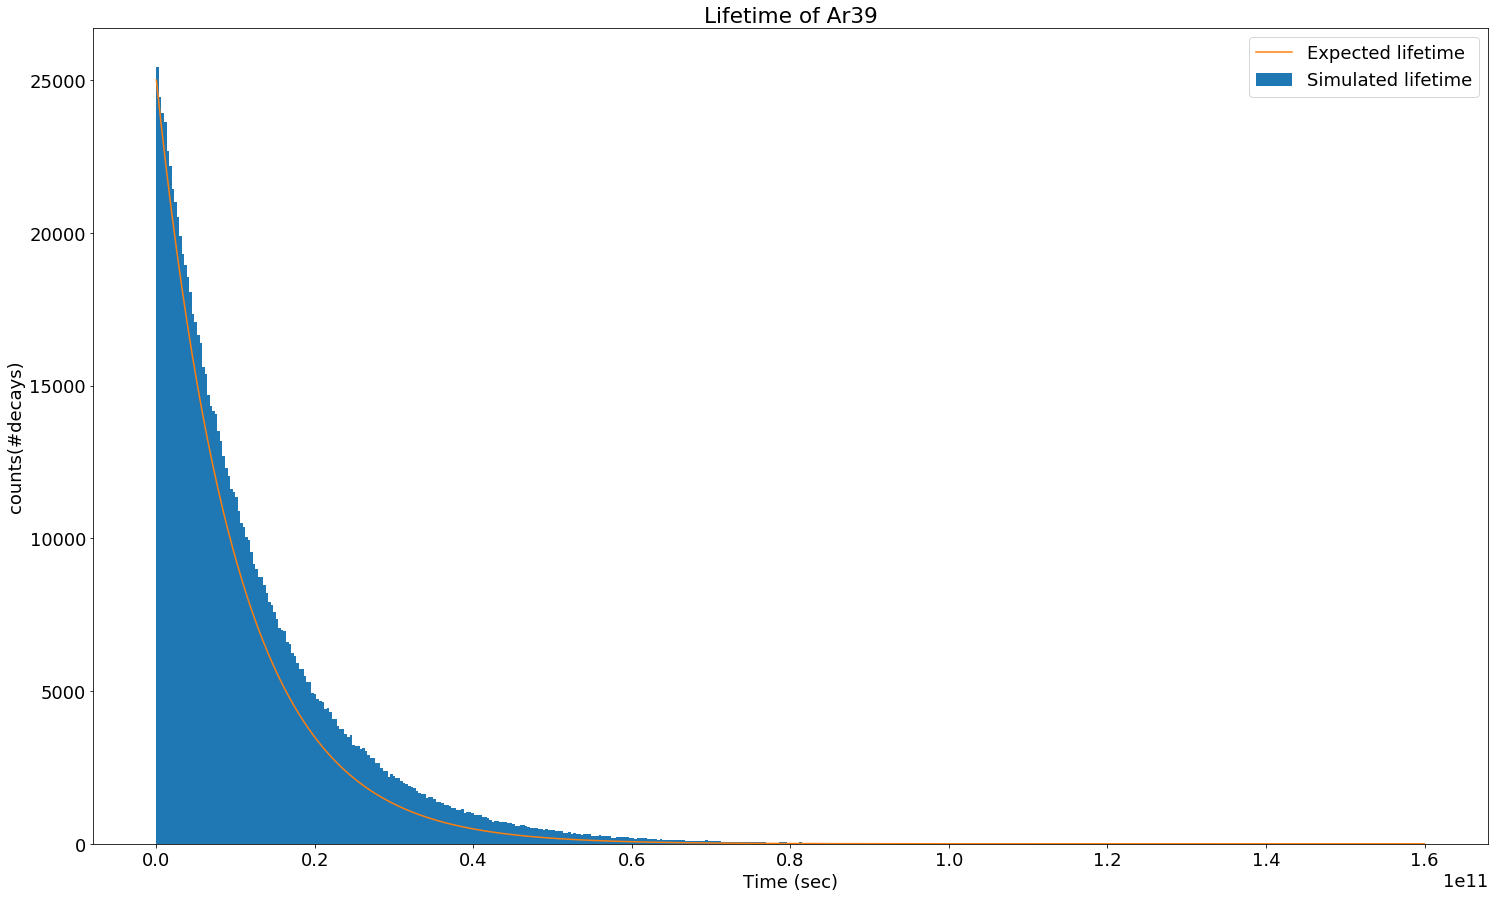

In [37]:
lin_bins = np.linspace(0, 1.6*10**11, 500)
plt.hist(entry_gb_decays.sec.first(), bins=lin_bins, label="Simulated lifetime")
plt.title("Lifetime of Ar39")
plt.xlabel("Time (sec)")
plt.ylabel("counts(#decays)")

halflife_tau = 8.46 * 10**9
tau = 0.6 * (2 * halflife_tau)    # Expected tau for full Ar39 decay
plt.plot(lin_bins, 25000*np.exp(-lin_bins/tau), label="Expected lifetime")
plt.legend()
plt.show()

## Analysis of space
In this section, we aim to analyse the space distribution of energy deposition. However, the current format doesn't contain the coordinate of Ar39 at decay time and reconstruct this information by Ar39 entries is not trivial (*not complete, and time consuming*).

Then, we propose to bound the energy depositions by a cubic volume, for each simulated decay.
To obtain this data, we simply compute the difference between maximum and minimum for each coordinate, and then compute the volume of the cube containing all the energy depositions.

This approximated measure gives us a bound on spatial spread of energy depositions from Ar39 decays.

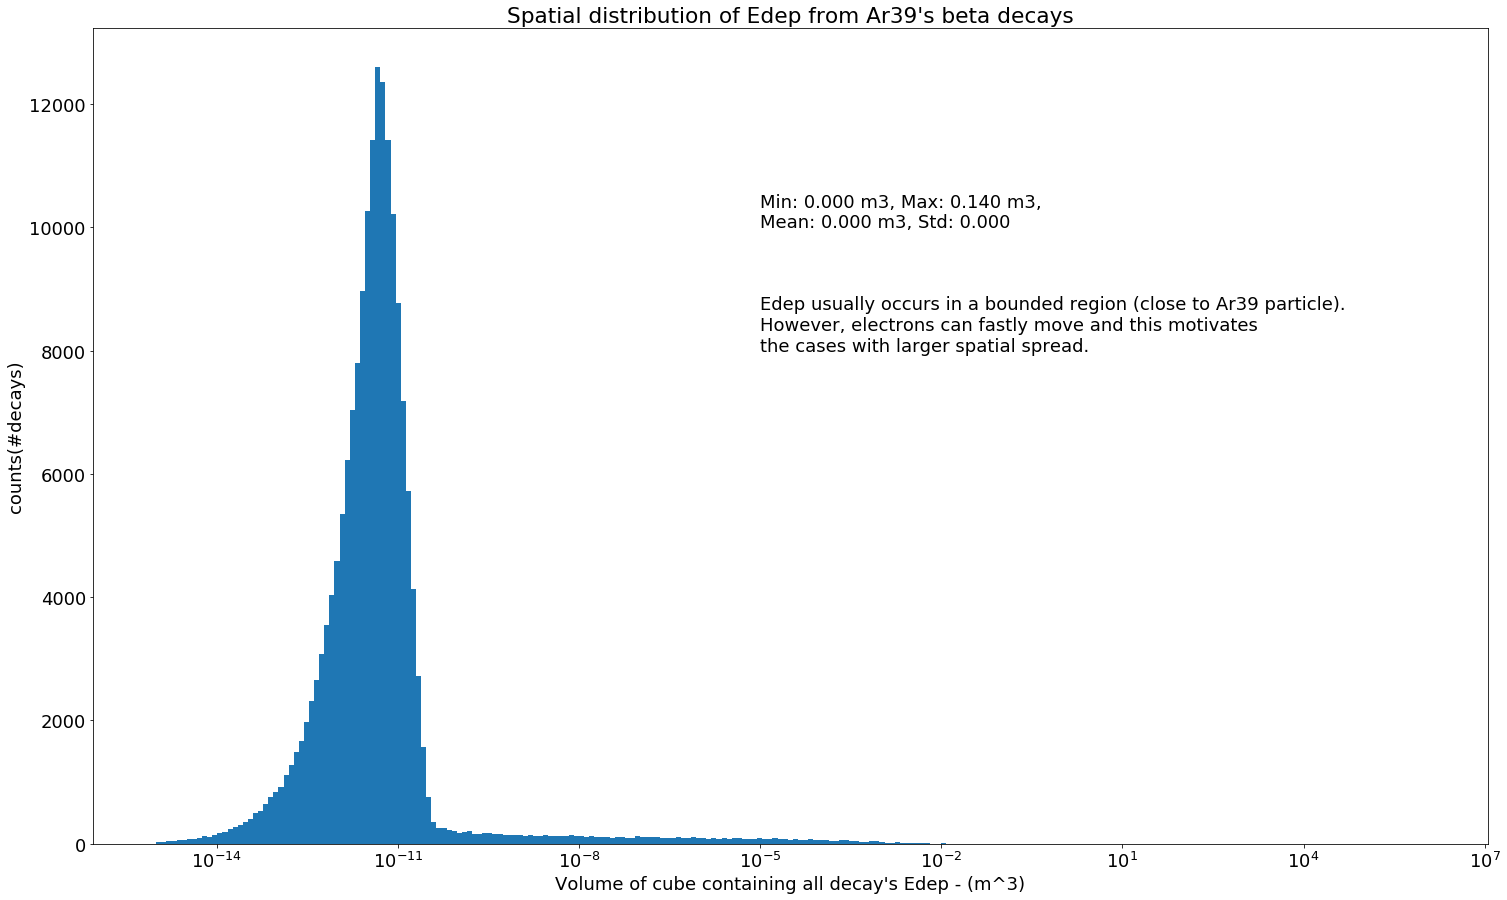

In [38]:
min_coord = entry_gb_decays[["x", "y", "z"]].min()
max_coord = entry_gb_decays[["x", "y", "z"]].max()
diff_coord = abs(max_coord - min_coord) / 1000    # convert in m
area_cube_decay = diff_coord.x * diff_coord.y * diff_coord.z

cube_stats = area_cube_decay.describe()

bins = np.logspace(-15, 6, 250)
plt.hist(area_cube_decay, bins=bins)
plt.xscale("log")
plt.xlabel("Volume of cube containing all decay's Edep - (m^3)")
plt.ylabel("counts(#decays)")
plt.title("Spatial distribution of Edep from Ar39's beta decays")
plt.text(10**-5, 8000, "Edep usually occurs in a bounded region (close to Ar39 particle).\n" \
                    "However, electrons can fastly move and this motivates\n" \
                    "the cases with larger spatial spread.")
plt.text(10**-5, 10000, "Min: {:.3f} m3, Max: {:.3f} m3,\nMean: {:.3f} m3, Std: {:.3f}".format(cube_stats.loc["min"], cube_stats.loc["max"], 
                                                                               cube_stats.loc["mean"], cube_stats.loc["std"]))
plt.show()

# Other random things (misc)

In [ ]:
time_bins = np.logspace(12, 21, 100)
plt.hist2d(df.time, df.energydeposition, bins=[100, 100])
plt.colorbar()
plt.xscale("log")
plt.xlabel("Time (ns) - Log Scale")
plt.ylabel("Step Energy-deposition (KeV)")
plt.show()

In [ ]:
first_edep_xevent = df.groupby("eventnumber").time.first()

In [ ]:
time = np.zeros(len(df))
import time as t
begin = t.time()
for i, (idx, row) in enumerate(df.iterrows()):
    if i%100000==0:
        print("Row {} - {} sec".format(i, t.time()-begin))
    time[i] = row.time - first_edep_xevent.loc[row.eventnumber]
time

In [ ]:
df['time_net'] = time.tolist()
df.head()

In [ ]:
stat_1_edep = first_edep_xevent.describe()
plt.subplot(2, 1, 1)
plt.hist(first_edep_xevent, bins=100, edgecolor="k")
#plt.xscale("log")
plt.title("Distribution of time of 1st edep>0 - Event-level info")
plt.xlabel("Time of 1st deposition (ns)")
plt.ylabel("counts (#events)")
plt.text(10**17, 500, "Mean:{:e} ns, Std:{:e}\n" \
                      "Min:{:e} ns, Max:{:e} ns".format(stat_1_edep.loc["mean"], 
                                                    stat_1_edep.loc["std"],
                                                    stat_1_edep.loc["min"],
                                                    stat_1_edep.loc["max"]))
plt.show()

plt.subplot(2, 1, 2)
plt.hist(df.time_net, bins=time_bins)
plt.xscale("log")
plt.title("Distribution of (time - (1stedep time)) - Step-level info")
plt.xlabel("Time of deposition w.r.t. event's 1st edep (ns)")
plt.ylabel("counts (#entries)")
plt.show()


In [ ]:
pd.DataFrame([df.time.describe(), df.time_net.describe()], index=["Time(step)", "Time Net(step)"])

In [ ]:
lst_describes = []
indices = []
nevents_in_interval = []
for i in range(1, 100+1):
    base = 10**19
    begin, end = (i-1)*base, i*base
    if i==0:
        nevents_in_interval.append(df[df.time<end].eventnumber.nunique())
        lst_describes.append(df[df.time<10**ex].energydeposition.describe())
        indices.append("Time<{:e}".format(end))
    else:
        nevents_in_interval.append(df[(df.time>=begin) & (df.time<end)].eventnumber.nunique())
        lst_describes.append(df[(df.time>=begin) & (df.time<end)].energydeposition.describe())
        indices.append("{:e}<=Time<{:e}".format(begin, end))
time_parts = pd.DataFrame(lst_describes, index=indices)
time_parts = time_parts.rename(columns={"count": "#entries"})
time_parts.insert(1, "#events", nevents_in_interval)
time_parts

In [ ]:
df.eventnumber.describe()

In [ ]:
first_edep_xevent.describe()

In [ ]:
event8064 = df[df.eventnumber==8064]
event8064[event8064.PID==1000190390]


In [ ]:
space_ar39 = df[df.PID==1000190390][["x", "y", "z"]]

In [ ]:
plt.hist((space_ar39.x**2 + space_ar39.y**2 + space_ar39.z**2)**.5, bins=100)
plt.show()

# Merge Ar39 simulations based on activity
CJ provides us individual Ar39 simulations, we will merge them according to the measured activity in liquid argon and the volume size.

In particular, we know from Mario Schwarz calculations:
- The instrumented volume is `2.6` m^3
- The measured activity of Ar39 in liquid argon is `1.41` Bq/l
- `1` m^3 of liquid argon corresponds to `1000` liters

Then, the number of Ar39 decays that we expect in one second is
`1.41 * 2.6 * 1000 = 3666`

From Giuseppe's note:
- Number of Ar39 per liter: `17.6*10^9` particle/liter
Then, the number of particles of Ar39 in 2.6m^3 is
`17.6*10^9 * 2600 = 45.76 * 10^12`. A lot!


In [ ]:
coords_gbevent = df.groupby("eventnumber")[["x", "y", "z"]]

In [ ]:
min_coords_perevent = coords_gbevent.min()
max_coords_perevent = coords_gbevent.max()

min_coords_perevent.head()


Each event will spread over the whole argon volume, it is not localized. In fact, each event has minimum x, y, z as lower limit of the coordinate, and maximum x, y, z as upper limit.

Then, we cannot find interesting pattern in localization of data, especially considering so-long events. **We should examin each beta emitted w.r.t. the coordinate where Ar39 decay occurs.**

In [ ]:
event8064 = df[df.eventnumber==8064]

In [ ]:
event8064.energydeposition.describe()

In [ ]:
e_gb_eventtrack = df.groupby(["eventnumber", "tracknumber"]).energydeposition.sum()
plt.hist(e_gb_eventtrack, bins=100)
plt.show()

**Questions:**
- Why the electron tracknumber is always the same? G4 reuse tracknumbers?